# Analyse und Outlier-Erkennung mit realistischen Sensor-Daten

Unser Datensatz enthält Sensor-Werte die in einem Wohnungskomplex aufgenommen wurden. Zusätzlich ist ein Sensor-Wert eines Getränkeautomaten hinzugefügt, der im Eingangsbereich der Liegenschaft aufgestellt ist. 

Dieser zusätzliche Sensor misst die Vibrationen des Kühl-Kompressors des Getränkeautomaten, Spalte 'vibration'. Die übrigen Variablen sind Messwerte zur Raum-Temperatur, Luftfeuchtigkeit, Luftdruck, Strom-Verbrauch, Batterielade-Stand und Raum-Beleuchtung.

Aufgaben:

1. Analyisieren Sie das Dataset, insbesondere die Werte-Verteilungen der verschiedenen Variablen
2. Normalisieren Sie alle Werte-Variable (MinMaxScaler)
3. Wenden Sie verschiedene Methoden für die Outlier-Bestimmung an (IQR, Std-Abweichung/ZScore, IsolationForest)
4. Vergleichen Sie das Resultat der verschiedenen Outlier-Erkennungen

Referenzen:

* https://www.analyticsvidhya.com/blog/2022/10/outliers-detection-using-iqr-z-score-lof-and-dbscan/
* https://scikit-learn.org/stable/modules/outlier_detection.html
* https://scikit-learn.org/stable/modules/outlier_detection.html#overview-of-outlier-detection-methods 

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set_theme(palette='Paired')

In [16]:
# Dataset einlesen
df_sensor = pd.read_csv('datasets/sensordata.csv')
df_sensor['date'] = pd.to_datetime(df_sensor['date'], format='mixed')
df_sensor.set_index('date', inplace=True)

In [17]:
# Informationen zum Dataset
df_sensor.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 127489 entries, 2020-09-12 21:38:12.041000+00:00 to 2019-04-21 14:41:30.307000+00:00
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   tenant       127489 non-null  object 
 1   temperature  37271 non-null   float64
 2   linkquality  127489 non-null  float64
 3   humidity     37270 non-null   float64
 4   pressure     37269 non-null   float64
 5   voltage      127433 non-null  float64
 6   illuminance  85646 non-null   float64
 7   battery      127433 non-null  float64
 8   vibration    127489 non-null  int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 9.7+ MB


In [18]:
# Wertebereiche
df_sensor.describe()

,temperature,linkquality,humidity,pressure,voltage,illuminance,battery,vibration
count,37271.000000,127489.000000,37270.000000,37269.000000,127433.000000,85646.000000,127433.000000,127489.000000
mean,20.608816,46.785966,67.912213,1003.134285,3005.022914,88.751629,93.594987,227.972217
std,3.411249,24.792719,8.428810,22.428442,24.362925,186.854643,14.372758,121.089217
min,11.340000,2.000000,30.160000,922.000000,2825.000000,0.000000,19.000000,9.000000
25%,18.030000,28.000000,63.050000,1004.000000,2985.000000,0.000000,91.000000,136.000000
50%,20.480000,44.000000,68.400000,1010.100000,3005.000000,8.000000,100.000000,214.000000
75%,23.390000,63.000000,73.390000,1014.900000,3025.000000,70.000000,100.000000,307.000000
max,35.330000,134.000000,95.470000,1032.000000,3075.000000,1000.000000,100.000000,654.000000


In [19]:
# Daten anzeigen
df_sensor.sample(10)

,tenant,temperature,linkquality,humidity,pressure,voltage,illuminance,battery,vibration
date,,,,,,,,,
2020-06-01 17:04:46.985000+00:00,sgh0201f6cb55ed.csv,NaN,57.0,NaN,NaN,3005.0,758.0,100.0,278
2020-01-14 21:47:14.613000+00:00,sgh0201e9248493.csv,NaN,31.0,NaN,NaN,3015.0,2.0,100.0,151
2019-09-04 10:50:30.779000+00:00,sgh02015d5c61cc.csv,NaN,13.0,NaN,NaN,3025.0,9.0,100.0,63
2019-10-01 07:36:53.304000+00:00,sgh020114a6a800.csv,NaN,44.0,NaN,NaN,2995.0,0.0,97.0,214
2019-03-16 08:17:51.330000+00:00,sgh020125bce03a.csv,14.0,76.0,75.86,1019.0,2975.0,NaN,37.0,371
2020-08-12 11:58:13.891000+00:00,sgh020177a7a91d.csv,NaN,36.0,NaN,NaN,3025.0,184.0,100.0,175
2020-03-07 09:31:50.796000+00:00,sgh020114a6a800.csv,NaN,60.0,NaN,NaN,2985.0,25.0,91.0,293
2019-05-09 21:58:10.466000+00:00,sgh02015d5c61cc.csv,NaN,31.0,NaN,NaN,3015.0,3.0,99.0,151
2020-01-24 02:22:07.195000+00:00,sgh0201a8c87da4.csv,NaN,86.0,NaN,NaN,2985.0,0.0,91.0,419


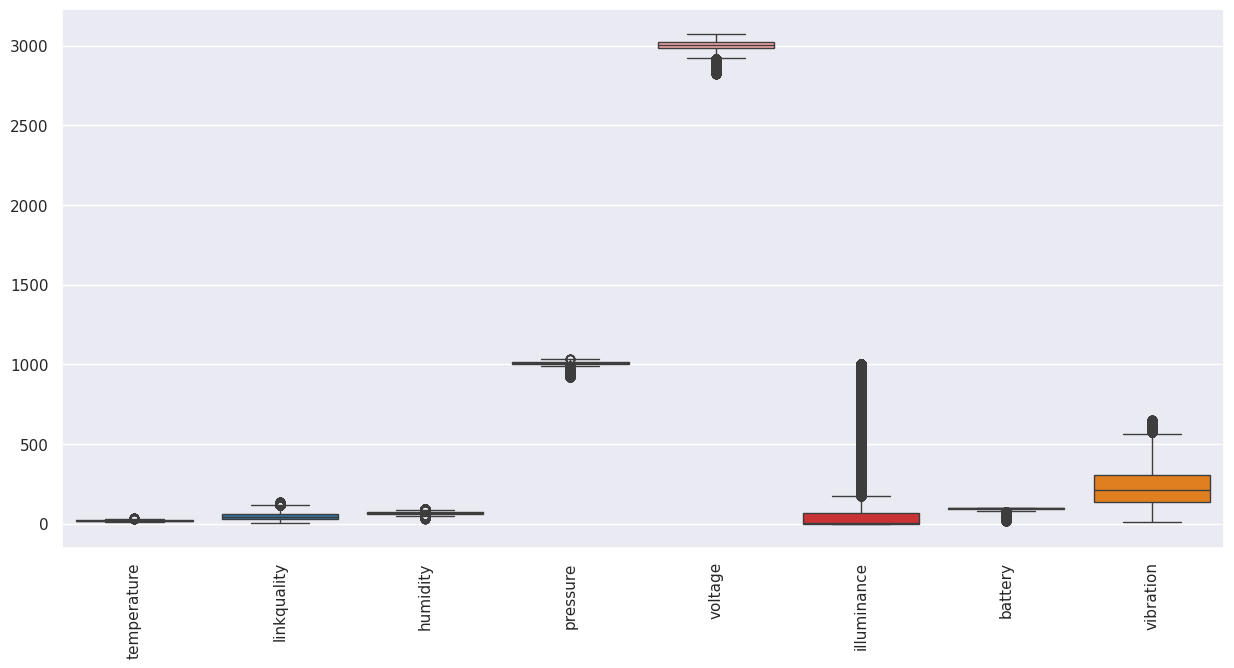

In [20]:
# Verteilungen in der Uebersicht
# -- Erstelle einen Boxplot aller Variablen
# -- Tip: Verwende z.B. plt.figure(figsize=[15,7]), um einen grösseren Plot zu erhalten
plt.figure(figsize=[15,7])
sns.boxplot(data=df_sensor)
plt.xticks(rotation=90)
plt.show()

In [21]:
# Normalisierung
# -- Berechne die normalisierten Werte aller numerischen Variablen
# -- Tip: nutze df.select_dtypes(include=np.number).columns, um alle numerischen Variablen zu erhalten
# -- Tip: nutze MinMaxScaler.fit_transform() um die normalisierten Werte zu erhalten
from sklearn.preprocessing import MinMaxScaler

columns = df_sensor.select_dtypes(include=np.number).columns
mxs = MinMaxScaler()
df_sensor[columns] = mxs.fit_transform(df_sensor[columns]) 

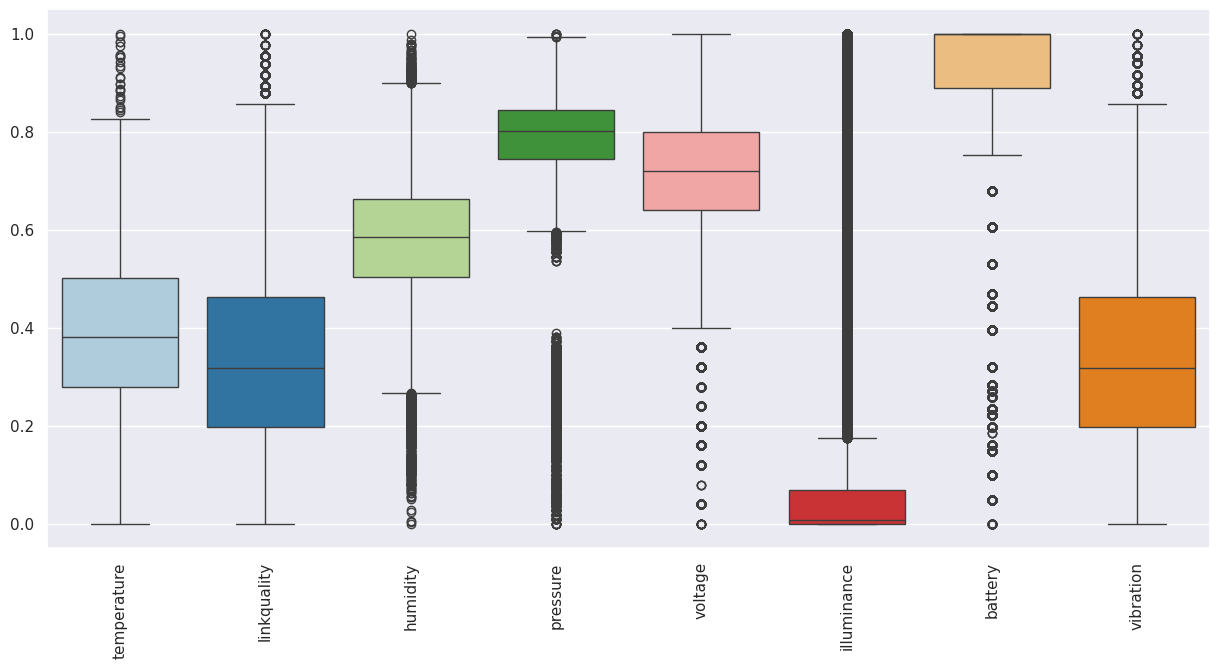

In [22]:
# Verteilungen in der Uebersicht mit normalisierten Variablen
# -- Erstelle einen Boxplot aller Variablen
# -- Tip: Verwende z.B. plt.figure(figsize=[15,7]), um einen grösseren Plot zu erhalten
plt.figure(figsize=[15,7])
sns.boxplot(data=df_sensor)
plt.xticks(rotation=90)
plt.show()

In [23]:
# Outlier nach Std / ZScore
# -- berechne die Spalte 'outlier' sodass Outlier jene Werte sind, die plus/minus einen Zscore von abs(3) aufweisen
# -- die Spalte 'outlier' soll -1 für Outlier, Normalwerte mit +1 bezeichnen
from scipy.stats import zscore
df_sensor['outlier'] = (zscore(df_sensor['vibration'])
                        .apply(lambda v: -1 if v >= 3 else 1))

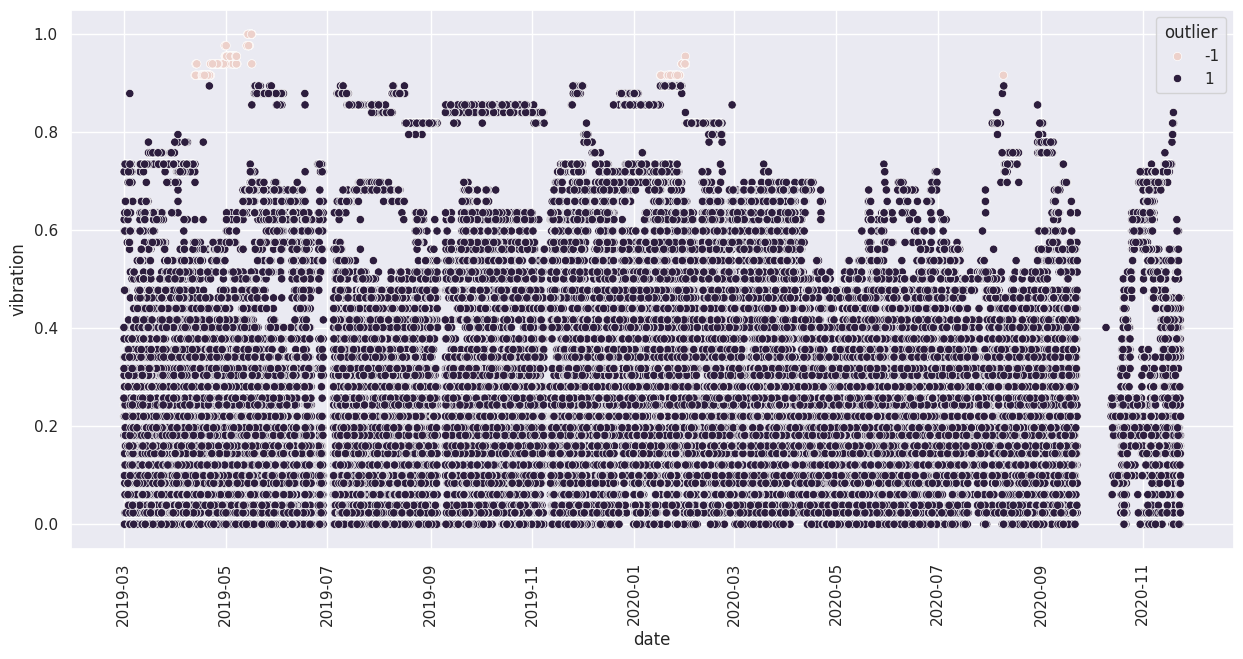

In [24]:
# Plotte die Outlier v.v. Normalwerte 
plt.figure(figsize=[15,7])
sns.scatterplot(data=df_sensor, 
                x=df_sensor.index, 
                y='vibration', hue='outlier')
plt.xticks(rotation=90)
plt.show()

In [25]:
# Berechne Outlier nach IQR
# -- berechne die Spalte 'outlier' sodass Outlier jene Werte sind, die +-1.5 IQR des unteren (.25) bzw. oberen Quartil (.75) liegen
# -- die Spalte 'outlier' soll -1 für Outlier, Normalwerte mit +1 bezeichnen
q1 = df_sensor['vibration'].quantile(.25)
q3 = df_sensor['vibration'].quantile(.75)
iqr = q3 - q1
cutoff = 1.5 * iqr # üblicherweise 1.5 
df_sensor['outlier'] = (df_sensor['vibration']
                        .apply(lambda v: (-1 if ((v <= q1 - cutoff) 
                                                 or (v >= q3 + cutoff))
                                          else 1))
                       )

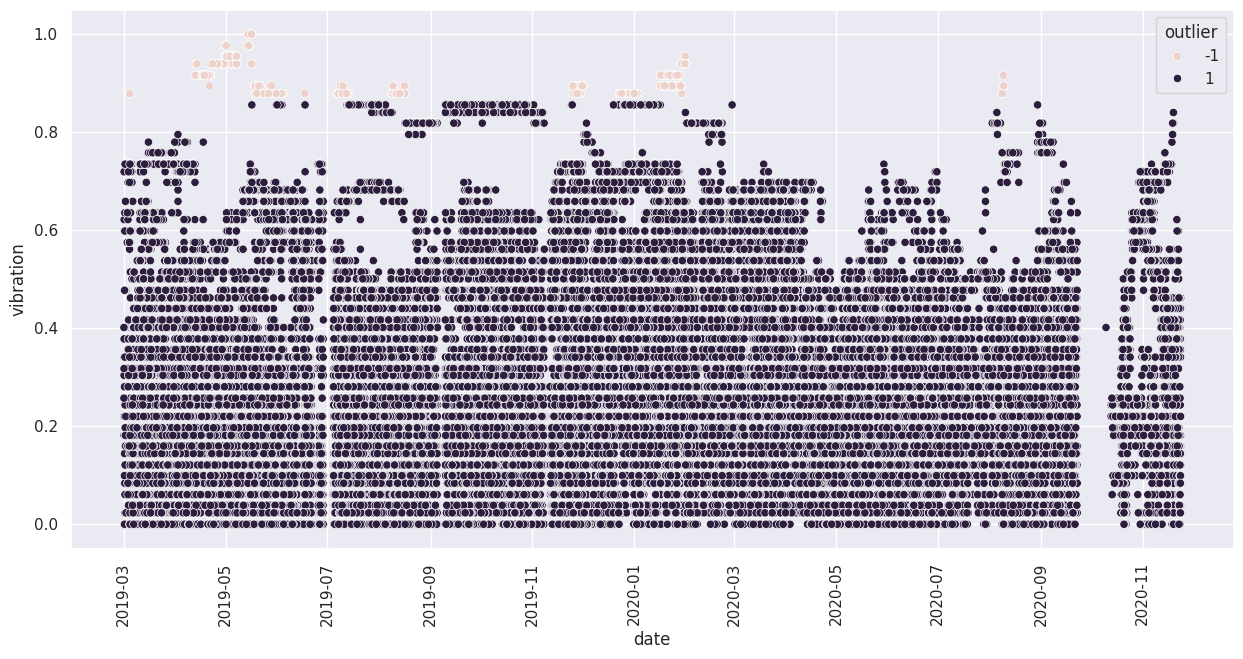

In [26]:
# Plotte die Outlier v.v. Normalwerte 
plt.figure(figsize=[15,7])
sns.scatterplot(data=df_sensor, 
                x=df_sensor.index, 
                y='vibration', hue='outlier')
plt.xticks(rotation=90)
plt.show()

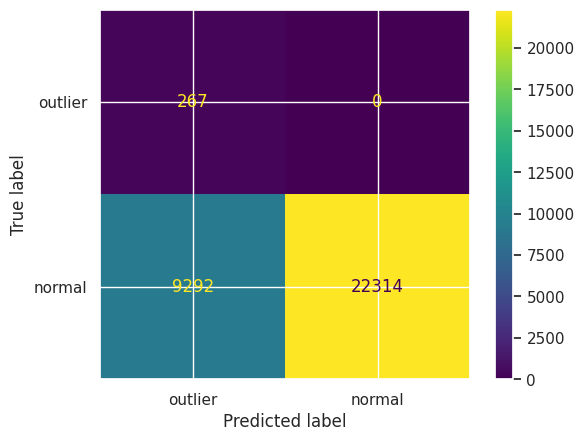

In [27]:
# Outlier nach IsolationForest 
# -- berechne die Spalte 'outlier' sodass Outlier jene Werte sind, die von einem IsolationForest Model als solche erkannt werden
# -- die Spalte 'outlier' soll -1 für Outlier, Normalwerte mit +1 bezeichnen
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

columns = df_sensor.select_dtypes(np.number).columns
columns = ['outlier', 'vibration']
# prepare data
dfx = (df_sensor[columns]
       .fillna(0))

df_train, df_test = train_test_split(dfx)
y_true = df_test['outlier']

# ensure we don't train our true value outlier
columns = list(set(columns) - set(['outlier']))

# train model
isf = IsolationForest()
isf.fit(df_train[columns])
y_test = isf.predict(df_test[columns])
df_test['predicted'] = y_test
# validate -- n.B. this validates against IQR based outlier detection: cannot expect high accuracy
cm = confusion_matrix(y_true, y_test)
cmplot = ConfusionMatrixDisplay(cm, display_labels=['outlier', 'normal'])
cmplot.plot()

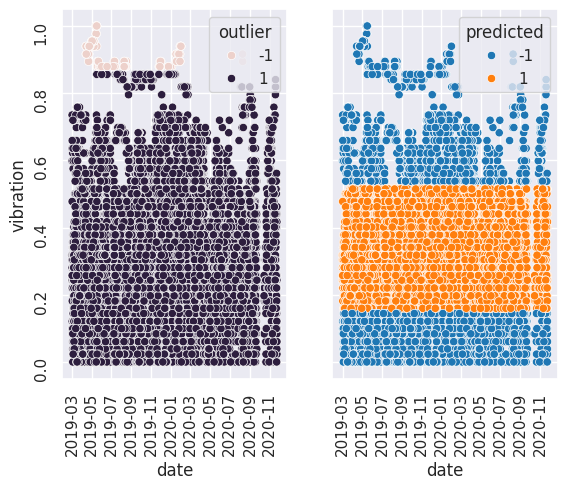

In [28]:
# Plot Outliers IQR vs. ISF 
# -- vergleiche Outlier nach IQR bzw. nach ISF
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
# plot known outliers
sns.scatterplot(df_test, 
                x=df_test.index, 
                y='vibration', 
                hue='outlier', 
                ax=axs[0])
# plot predicted outliers
sns.scatterplot(df_test, 
                x=df_test.index, 
                y='vibration', 
                hue='predicted', 
                palette='tab10', 
                ax=axs[1])
for ax in axs:
    ax.tick_params(labelrotation=90)
plt.show()